# MultiScaleFractionalGenerator example

In this example, the fluctuation function is given by two asymptotes, with slopes H1 at small scales (high frequencies) and H0 at large scales (low frequencies), with a point of convergence in Sx.

The output displays the specified asymptotes (dotted lines) and the empirical FF (in red).

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from StatTools.analysis.dpcca import dpcca
from StatTools.analysis import analyse_cross_ff
from StatTools.generators.multi_scale_fractional_generator import (
    MultiScaleFractionalGenerator,
)
from StatTools.visualization import plot_ff


In [2]:
n_tracks = 8
length = 2**20
h_list = [0.8, 2.2]  # [H0, H1]
crossover_points = [2**3]  # [Sx]

In [3]:
gen = MultiScaleFractionalGenerator(h_list=h_list, crossover_points=crossover_points)
correlation_matrix = 0.5 * (
                np.ones((n_tracks, n_tracks)) - np.eye(n_tracks)
            ) + np.eye(n_tracks)

signals = gen.generate(length, n_tracks, correlation_matrix=correlation_matrix)
signals.shape

(8, 1048576)

In [4]:
S = 2 ** np.arange(3, int(np.log2(length)) + 1)
step = 0.5
threads = 4

p1, r1, f1, s1 = dpcca(signals, 2, step, S, processes=threads, n_integral=1)
s1 = np.array(s1)

	DPCAA warning: only following S values are in use: [np.int64(8), np.int64(16), np.int64(32), np.int64(64), np.int64(128), np.int64(256), np.int64(512), np.int64(1024), np.int64(2048), np.int64(4096), np.int64(8192), np.int64(16384), np.int64(32768), np.int64(65536), np.int64(131072), np.int64(262144)]


In [5]:
F = np.transpose(f1, (1, 2, 0))
F0 = F * np.eye(F.shape[0])[:, :, None]
F0[F0 == 0] = np.nan

# The average FF on the diagonal
Fs_ave = np.sqrt(np.nanmean(F0, axis=(0, 1)))
Fs_ave /= Fs_ave[0]

In [6]:
ff_params, residuals = analyse_cross_ff(Fs_ave.reshape(1, len(Fs_ave)), s1, crossover_amount=1)

In [7]:
print("=" * 50)
print(f"{'FF PARAMETERS':^50}")
print("=" * 50)

print("\nCROSS POINTS:")
print("-" * 40)
for i in range(len(ff_params.cross)):
    print(
        f"  Point {i+1:2d}: {ff_params.cross[i].value:>6.2f} ± {ff_params.cross[i].stderr:<6.2f}"
    )

print("\nSLOPES:")
print("-" * 40)
for i in range(len(ff_params.slopes)):
    print(
        f"  Slope {i+1:2d}: {ff_params.slopes[i].value:>6.2f} ± {ff_params.slopes[i].stderr:<6.2f}"
    )
print("=" * 50)

                  FF PARAMETERS                   

CROSS POINTS:
----------------------------------------
  Point  1:  13.36 ± 2.06  

SLOPES:
----------------------------------------
  Slope  1:   9.30 ± 12.33 
  Slope  2:   0.89 ± 0.01  


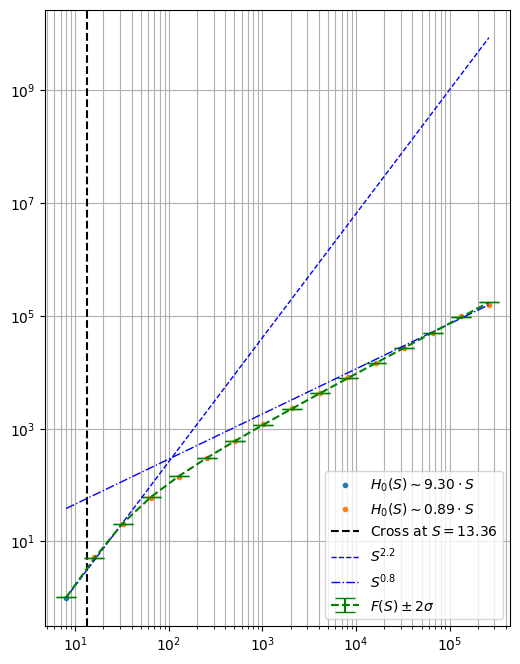

In [8]:
fig, ax = plt.subplots(figsize=(6, 8))
plot_ff(
    Fs_ave.reshape(1, len(Fs_ave)),
    s1,
    ff_parameter=ff_params,
    residuals=residuals,
    ax=ax
)
plt.loglog(
    s1, s1 ** h_list[1] / s1[0] ** h_list[1], "b--", linewidth=1, label=rf"$S^{{{h_list[1]}}}$"
)
plt.loglog(
    s1,
    s1 ** h_list[0] / s1[-1] ** h_list[0] * Fs_ave[-1],
    "b-.",
    linewidth=1,
    label=rf"$S^{{{h_list[0]}}}$",
)
plt.legend()
plt.show()

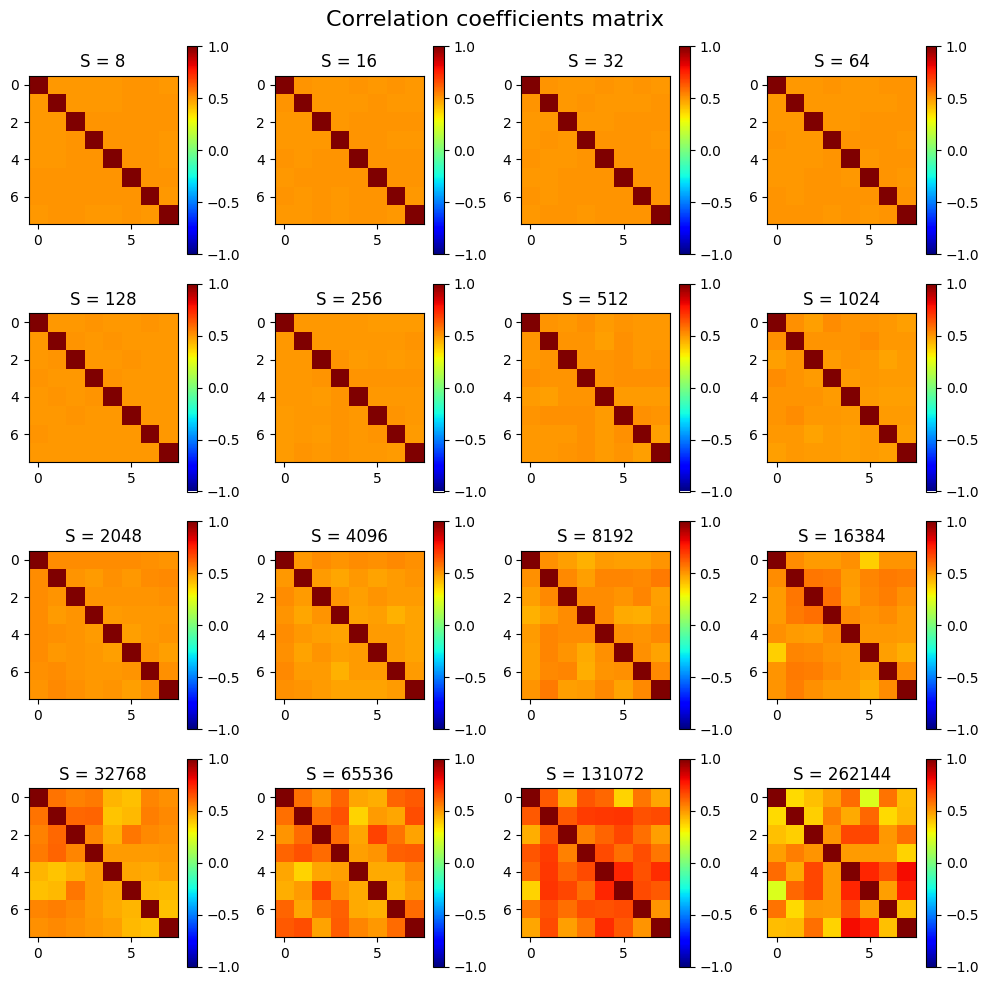

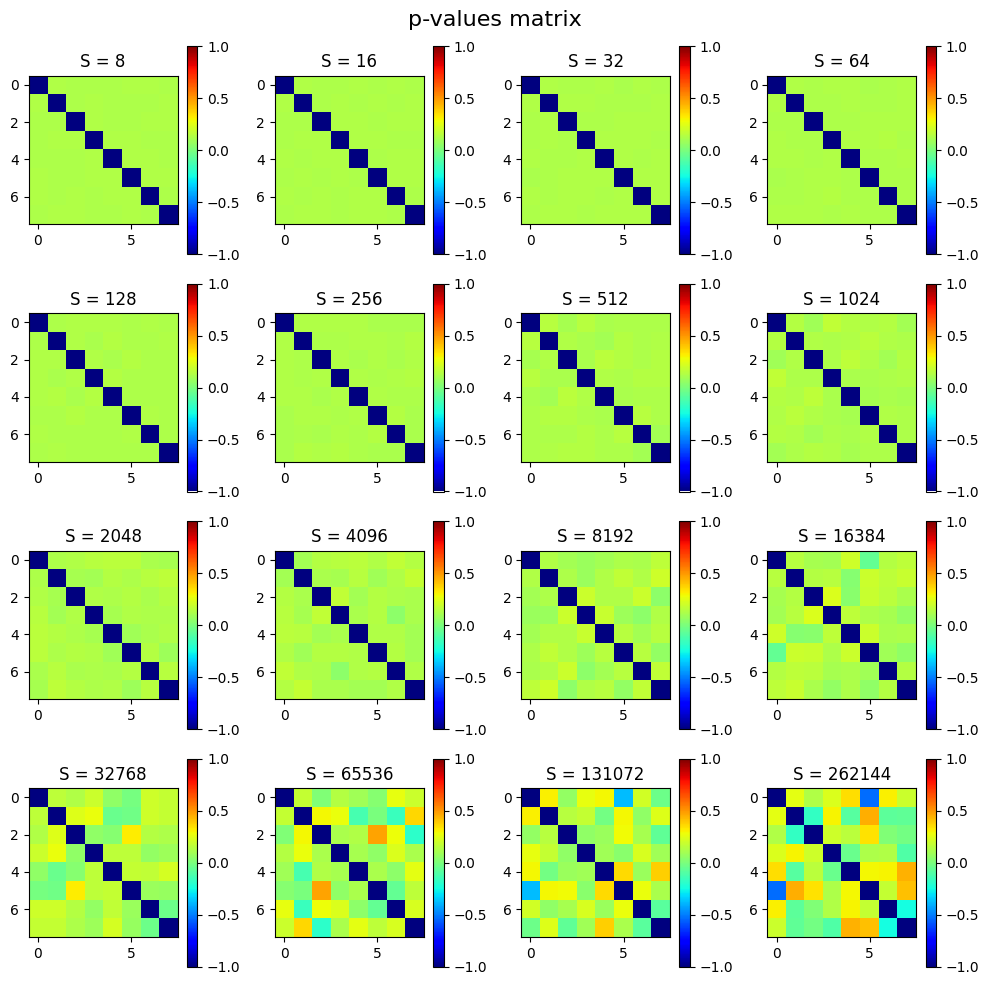

In [10]:
plt.figure(figsize=(10, 10))
plt.suptitle("Correlation coefficients matrix", fontsize=16)
for i in range(len(s1)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(r1[i, :, :], vmin=-1, vmax=1, cmap="jet")
    plt.colorbar()
    plt.title(f"S = {s1[i]}")
plt.tight_layout(rect=[0, 0, 1, 1])

plt.figure(figsize=(10, 10))
plt.suptitle("p-values matrix", fontsize=16)
for i in range(len(s1)):
    plt.subplot(4, 4, i + 1)
    plt.imshow(p1[i, :, :], vmin=-1, vmax=1, cmap="jet")
    plt.colorbar()
    plt.title(f"S = {s1[i]}")
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()

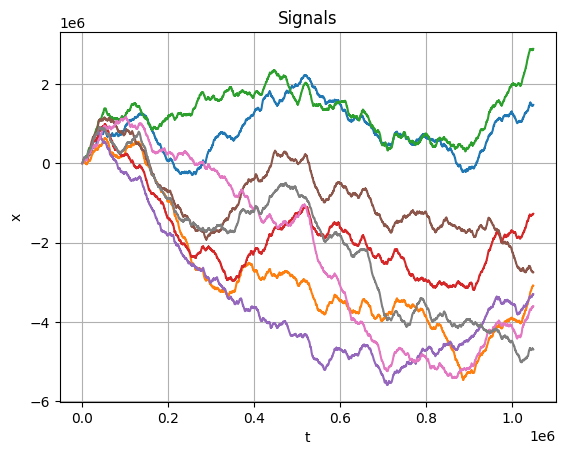

In [11]:
for signal in signals:
    plt.plot(np.cumsum(signal))
plt.xlabel("t")
plt.ylabel("x")
plt.title("Signals")
plt.grid(True)
plt.show()